## Collaborators 
- Kyle Carlo Lasala
- Katrina Bianca Roco
- Antonio Jose Maria Lorenzo
- Charles Joseph Hinolan

## Preliminaries

### Import libraries

We will be using the `PyFIM` library to do association rule learning in this homework. If this is not already installed in your environment, you may use the either of the following commands in your command line:

```conda install -c conda-forge pyfim``` or
```pip install pyfim```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fim import arules, apriori, fpgrowth

In [2]:
path = r"dataset.csv"
df = pd.read_csv(path, index_col=0)
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [3]:
# checking datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           114000 

## Data Preprocessing

#### Dropping Null Values

In [4]:
df.isnull().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [5]:
df = df.dropna()

#### Removing Duplicates

In [6]:
print(df['track_id'].duplicated().sum())

24259


In [7]:
df['track_id'].value_counts().head(10)

track_id
6S3JlDAGk3uu3NtZbPnuhS    9
2Ey6v4Sekh3Z0RUSISRosD    8
2kkvB3RNRzwjFdGhaUA0tz    8
08kTa3SL9sV6Iy8KLKtGql    7
4XYieGKSlJlHpzB3bl6WMP    7
5ZsAhuQ24mWHiduaxJqnhW    7
0YLSjVxSb5FT1Bo8Tnxr8j    7
4WJTKbNJQ41zXnb84jSWaj    7
2aaClnypAakdAmLw74JXxB    7
2vU6bm5hVF2idVknGzqyPL    7
Name: count, dtype: int64

Retain the most popular version of each song

In [8]:
df = df.sort_values(by='popularity', ascending=False).drop_duplicates(subset='track_id').reset_index(drop=True)
print(df['track_id'].duplicated().sum())

0


#### Preprocessing Int Columns

In [9]:
int_cols = df.select_dtypes(include=['int64']).columns
int_cols

Index(['popularity', 'duration_ms', 'key', 'mode', 'time_signature'], dtype='object')

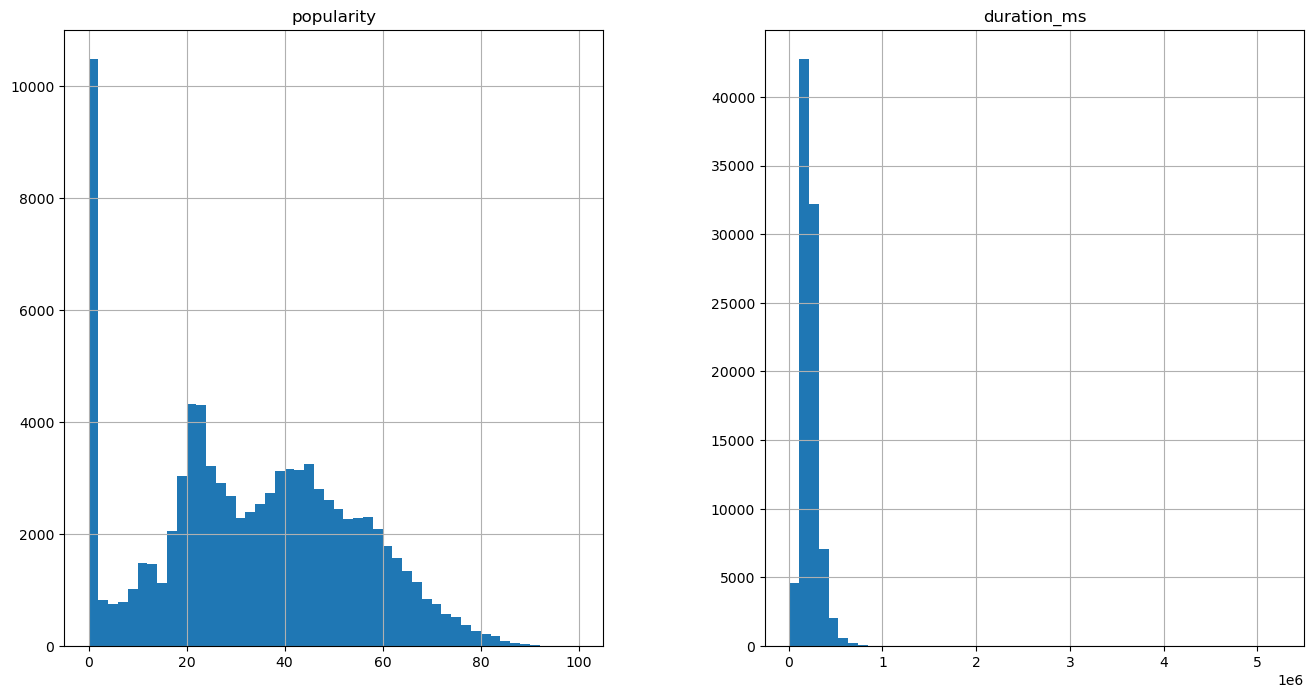

In [10]:
int_cols = ['popularity','duration_ms']
df[int_cols].hist(figsize=(16, 8),bins=50)
plt.show()

Binning of Int Columns

In [11]:
# range and stdev as the bin criteria → if data is more dispersed, assign more bins to capture data granularity
three_bin = []
five_bin = []

for x in int_cols:
    val_range = df[x].max() - df[x].min()
    std = df[x].std()
    if val_range < 3 * std:
        three_bin.append(x)
    else:
        five_bin.append(x)

print("Columns with 3 bins:", three_bin)
print("Columns with 5 bins:", five_bin)

Columns with 3 bins: []
Columns with 5 bins: ['popularity', 'duration_ms']


In [12]:
labels_3 = ['Low', 'Medium', 'High']
labels_5 = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

df_bins = df[['track_id']].copy()

for col in three_bin:
    df_bins[col + '_bin'] = pd.cut(df[col], bins=3, labels=labels_3)

for col in five_bin:
    df_bins[col + '_bin'] = pd.cut(df[col], bins=5, labels=labels_5)

df_bins_int = df_bins
df_bins

,track_id,popularity_bin,duration_ms_bin
0,3nqQXoyQOWXiESFLlDF1hG,Very High,Very Low
1,2tTmW7RDtMQtBk7m2rYeSw,Very High,Very Low
2,5ww2BF9slyYgNOk37BlC4u,Very High,Very Low
3,4uUG5RXrOk84mYEfFvj3cK,Very High,Very Low
4,1IHWl5LamUGEuP4ozKQSXZ,Very High,Very Low
...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,Very Low,Very Low
89736,4WCpgL2vHyx2vusJ5mbBnF,Very Low,Very Low
89737,5FImqqYMK6ZwLwClPDds8c,Very Low,Very Low
89738,4BsasVXlffiJ69bRrJXWZO,Very Low,Very Low


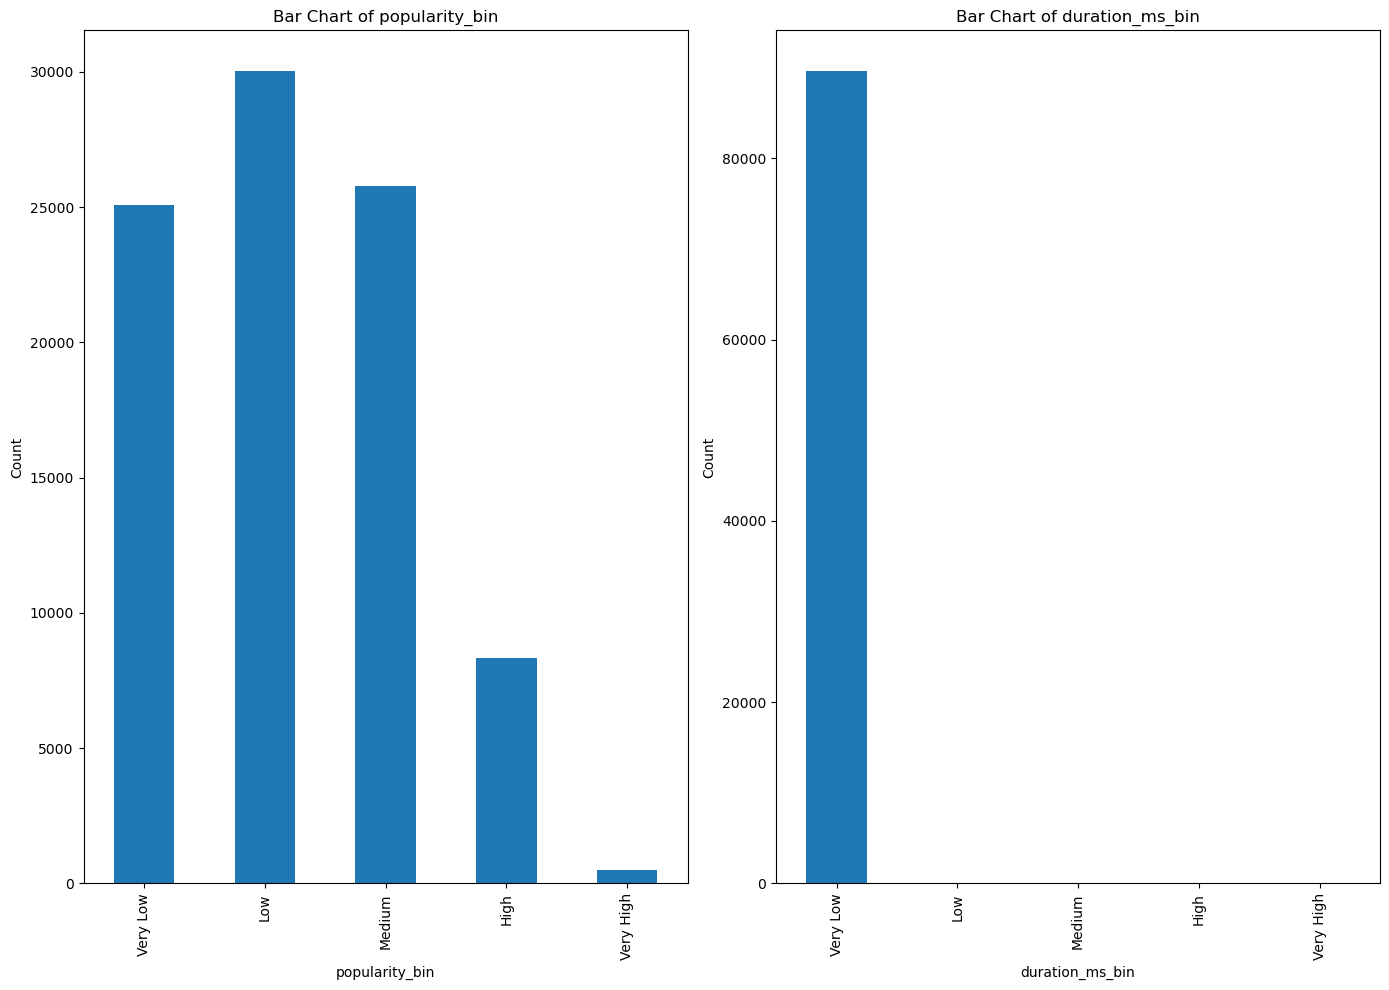

In [13]:
binned_cols = [col for col in df_bins.columns if col.endswith('_bin')]

fig, axes = plt.subplots(1,2,figsize=(14, 10))
axes = axes.flatten()

for i, x in enumerate(binned_cols):
    value_counts = df_bins[x].value_counts().sort_index()
    bars = value_counts.plot(kind='bar', ax=axes[i])

    axes[i].set_title(f"Bar Chart of {x}")
    axes[i].set_xlabel(x)
    axes[i].set_ylabel("Count")


plt.tight_layout()
plt.show()

One Hat Encode Int Columns

In [14]:
df_int_encoded = pd.get_dummies(df_bins[binned_cols])
df_int_encoded = pd.concat([df_bins[['track_id']], df_int_encoded], axis=1)
df_int_encoded

,track_id,popularity_bin_Very Low,popularity_bin_Low,popularity_bin_Medium,popularity_bin_High,popularity_bin_Very High,duration_ms_bin_Very Low,duration_ms_bin_Low,duration_ms_bin_Medium,duration_ms_bin_High,duration_ms_bin_Very High
0,3nqQXoyQOWXiESFLlDF1hG,False,False,False,False,True,True,False,False,False,False
1,2tTmW7RDtMQtBk7m2rYeSw,False,False,False,False,True,True,False,False,False,False
2,5ww2BF9slyYgNOk37BlC4u,False,False,False,False,True,True,False,False,False,False
3,4uUG5RXrOk84mYEfFvj3cK,False,False,False,False,True,True,False,False,False,False
4,1IHWl5LamUGEuP4ozKQSXZ,False,False,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,True,False,False,False,False,True,False,False,False,False
89736,4WCpgL2vHyx2vusJ5mbBnF,True,False,False,False,False,True,False,False,False,False
89737,5FImqqYMK6ZwLwClPDds8c,True,False,False,False,False,True,False,False,False,False
89738,4BsasVXlffiJ69bRrJXWZO,True,False,False,False,False,True,False,False,False,False


#### Preprocessing Float Columns

In [15]:
float_cols = df.select_dtypes(include=['float64']).columns
df[float_cols].describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000
mean,0.562166,0.634458,-8.498994,0.087442,0.328285,0.173415,0.216971,0.469474,122.058134
std,0.176692,0.256606,5.221518,0.113278,0.338321,0.323849,0.194885,0.262864,30.117651
min,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.450000,0.457000,-10.322250,0.036000,0.017100,0.000000,0.098200,0.249000,99.262750
50%,0.576000,0.676000,-7.185000,0.048900,0.188000,0.000058,0.132000,0.457000,122.013000
75%,0.692000,0.853000,-5.108000,0.085900,0.625000,0.097625,0.279000,0.682000,140.077000
max,0.985000,1.000000,4.532000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000


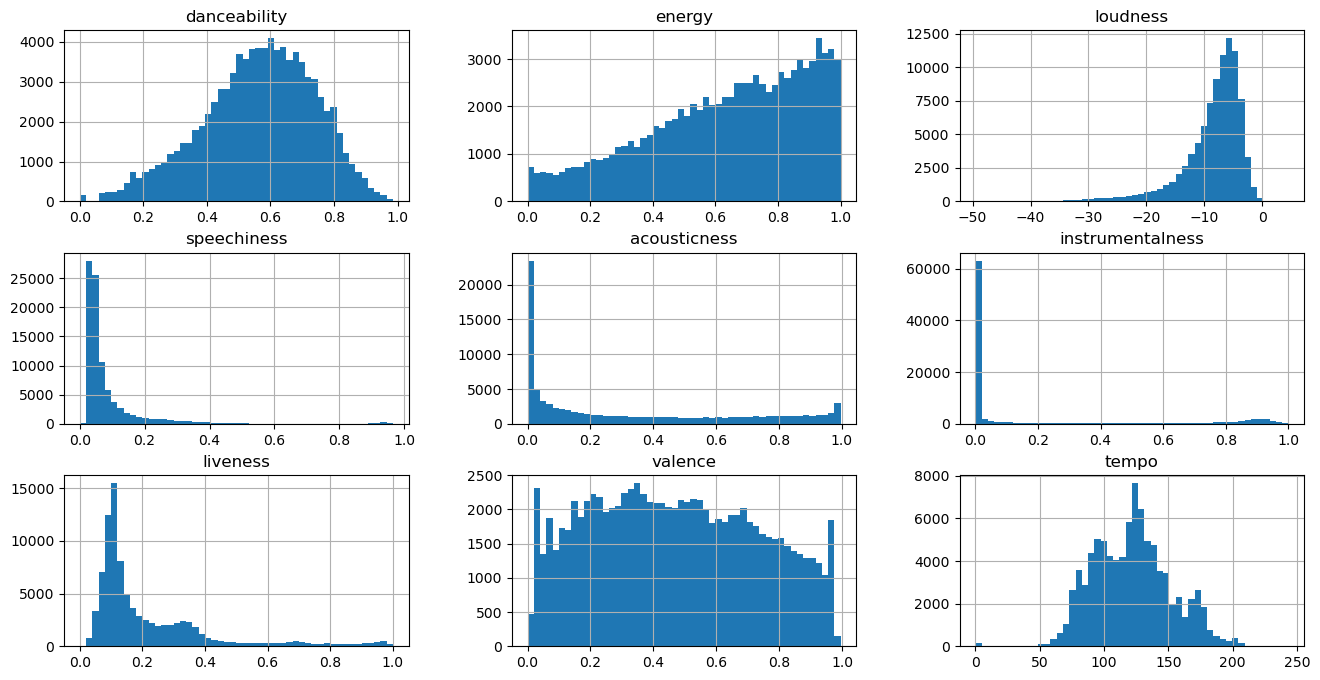

In [16]:
df[float_cols].hist(figsize=(16, 8),bins=50)
plt.show()

Binning of Float Columns

In [17]:
# range and stdev as the bin criteria → if data is more dispersed, assign more bins to capture data granularity
three_bins = []
five_bins = []

for x in float_cols:
    val_range = df[x].max() - df[x].min()
    std = df[x].std()
    if x == 'speechiness':  # based on kaggle column description → 3 bins
        three_bins.append(x)
    elif val_range < 3 * std:
        three_bins.append(x)
    else:
        five_bins.append(x)

print("Columns with 3 bins:", three_bins)
print("Columns with 5 bins:", five_bins)

Columns with 3 bins: ['speechiness', 'acousticness']
Columns with 5 bins: ['danceability', 'energy', 'loudness', 'instrumentalness', 'liveness', 'valence', 'tempo']


In [18]:
df_bins = df[['track_id']].copy()

for x in three_bins:
    df_bins[x + '_bin'] = pd.cut(df[x], bins=3, labels=labels_3)

for x in five_bins:
    df_bins[x + '_bin'] = pd.cut(df[x], bins=5, labels=labels_5)

df_bins_float = df_bins
df_bins

,track_id,speechiness_bin,acousticness_bin,danceability_bin,energy_bin,loudness_bin,instrumentalness_bin,liveness_bin,valence_bin,tempo_bin
0,3nqQXoyQOWXiESFLlDF1hG,Low,Low,High,Medium,High,Very Low,Low,Low,Medium
1,2tTmW7RDtMQtBk7m2rYeSw,Low,Low,High,High,Very High,Very Low,Low,Medium,Medium
2,5ww2BF9slyYgNOk37BlC4u,Low,Medium,Very High,High,Very High,Very Low,Low,Very High,Medium
3,4uUG5RXrOk84mYEfFvj3cK,Low,Low,Medium,Very High,Very High,Very Low,Low,Low,Medium
4,1IHWl5LamUGEuP4ozKQSXZ,Low,Low,High,High,Very High,Very Low,Very Low,Very Low,Medium
...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,Low,Low,High,High,Very High,Very Low,Very Low,High,Medium
89736,4WCpgL2vHyx2vusJ5mbBnF,Low,Low,High,Very High,Very High,Very Low,Low,Medium,Medium
89737,5FImqqYMK6ZwLwClPDds8c,Low,Low,High,High,Very High,Very Low,Very Low,High,Medium
89738,4BsasVXlffiJ69bRrJXWZO,Low,Low,High,High,Very High,Very Low,Very Low,High,Medium


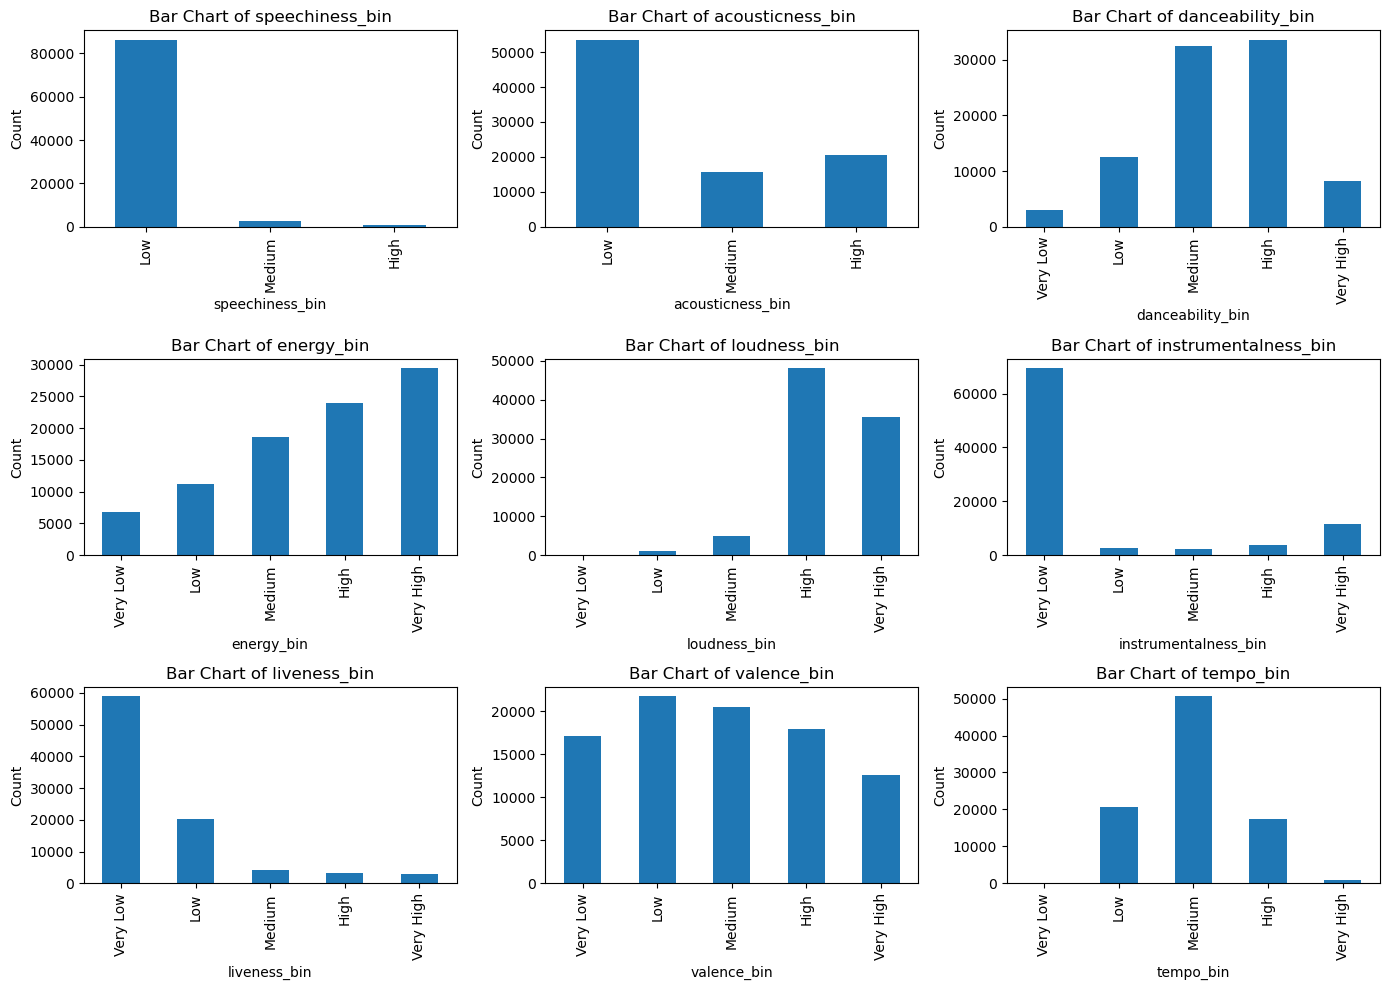

In [19]:
binned_cols = [col for col in df_bins.columns if col.endswith('_bin')]

fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()

for i, x in enumerate(binned_cols):
    value_counts = df_bins[x].value_counts().sort_index()
    bars = value_counts.plot(kind='bar', ax=axes[i])

    axes[i].set_title(f"Bar Chart of {x}")
    axes[i].set_xlabel(x)
    axes[i].set_ylabel("Count")


plt.tight_layout()
plt.show()

One Hat Encode Float Columns

In [20]:
df_flt_encoded = pd.get_dummies(df_bins[binned_cols])
df_flt_encoded = pd.concat([df_bins[['track_id']], df_flt_encoded], axis=1)
df_flt_encoded

,track_id,speechiness_bin_Low,speechiness_bin_Medium,speechiness_bin_High,acousticness_bin_Low,acousticness_bin_Medium,acousticness_bin_High,danceability_bin_Very Low,danceability_bin_Low,danceability_bin_Medium,...,valence_bin_Very Low,valence_bin_Low,valence_bin_Medium,valence_bin_High,valence_bin_Very High,tempo_bin_Very Low,tempo_bin_Low,tempo_bin_Medium,tempo_bin_High,tempo_bin_Very High
0,3nqQXoyQOWXiESFLlDF1hG,True,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
1,2tTmW7RDtMQtBk7m2rYeSw,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2,5ww2BF9slyYgNOk37BlC4u,True,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
3,4uUG5RXrOk84mYEfFvj3cK,True,False,False,True,False,False,False,False,True,...,False,True,False,False,False,False,False,True,False,False
4,1IHWl5LamUGEuP4ozKQSXZ,True,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
89736,4WCpgL2vHyx2vusJ5mbBnF,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
89737,5FImqqYMK6ZwLwClPDds8c,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
89738,4BsasVXlffiJ69bRrJXWZO,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False


### Merge

In [21]:
# merge binned int and float vars into one dataframe
df_merged = df_int_encoded.merge(df_flt_encoded, on='track_id', how='inner')
df_merged

,track_id,popularity_bin_Very Low,popularity_bin_Low,popularity_bin_Medium,popularity_bin_High,popularity_bin_Very High,duration_ms_bin_Very Low,duration_ms_bin_Low,duration_ms_bin_Medium,duration_ms_bin_High,...,valence_bin_Very Low,valence_bin_Low,valence_bin_Medium,valence_bin_High,valence_bin_Very High,tempo_bin_Very Low,tempo_bin_Low,tempo_bin_Medium,tempo_bin_High,tempo_bin_Very High
0,3nqQXoyQOWXiESFLlDF1hG,False,False,False,False,True,True,False,False,False,...,False,True,False,False,False,False,False,True,False,False
1,2tTmW7RDtMQtBk7m2rYeSw,False,False,False,False,True,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2,5ww2BF9slyYgNOk37BlC4u,False,False,False,False,True,True,False,False,False,...,False,False,False,False,True,False,False,True,False,False
3,4uUG5RXrOk84mYEfFvj3cK,False,False,False,False,True,True,False,False,False,...,False,True,False,False,False,False,False,True,False,False
4,1IHWl5LamUGEuP4ozKQSXZ,False,False,False,False,True,True,False,False,False,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,True,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False
89736,4WCpgL2vHyx2vusJ5mbBnF,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False
89737,5FImqqYMK6ZwLwClPDds8c,True,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False
89738,4BsasVXlffiJ69bRrJXWZO,True,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False


In [22]:
# add `explicit` feature
df_merged = df_merged.merge(df[['track_id', 'explicit']], on='track_id', how='left')
df_merged

,track_id,popularity_bin_Very Low,popularity_bin_Low,popularity_bin_Medium,popularity_bin_High,popularity_bin_Very High,duration_ms_bin_Very Low,duration_ms_bin_Low,duration_ms_bin_Medium,duration_ms_bin_High,...,valence_bin_Low,valence_bin_Medium,valence_bin_High,valence_bin_Very High,tempo_bin_Very Low,tempo_bin_Low,tempo_bin_Medium,tempo_bin_High,tempo_bin_Very High,explicit
0,3nqQXoyQOWXiESFLlDF1hG,False,False,False,False,True,True,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1,2tTmW7RDtMQtBk7m2rYeSw,False,False,False,False,True,True,False,False,False,...,False,True,False,False,False,False,True,False,False,False
2,5ww2BF9slyYgNOk37BlC4u,False,False,False,False,True,True,False,False,False,...,False,False,False,True,False,False,True,False,False,False
3,4uUG5RXrOk84mYEfFvj3cK,False,False,False,False,True,True,False,False,False,...,True,False,False,False,False,False,True,False,False,True
4,1IHWl5LamUGEuP4ozKQSXZ,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
89736,4WCpgL2vHyx2vusJ5mbBnF,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,True,False,False,False
89737,5FImqqYMK6ZwLwClPDds8c,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
89738,4BsasVXlffiJ69bRrJXWZO,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [23]:
genres = pd.concat([df['track_id'], pd.get_dummies(df['track_genre'])], axis=1)
df_merged = df_merged.merge(genres, on='track_id', how='left')
df_merged

,track_id,popularity_bin_Very Low,popularity_bin_Low,popularity_bin_Medium,popularity_bin_High,popularity_bin_Very High,duration_ms_bin_Very Low,duration_ms_bin_Low,duration_ms_bin_Medium,duration_ms_bin_High,...,spanish,study,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,world-music
0,3nqQXoyQOWXiESFLlDF1hG,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2tTmW7RDtMQtBk7m2rYeSw,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,5ww2BF9slyYgNOk37BlC4u,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4uUG5RXrOk84mYEfFvj3cK,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1IHWl5LamUGEuP4ozKQSXZ,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89735,4VnsZmAkvBEX5BWxMAWBBG,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89736,4WCpgL2vHyx2vusJ5mbBnF,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89737,5FImqqYMK6ZwLwClPDds8c,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89738,4BsasVXlffiJ69bRrJXWZO,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [24]:
df_merged2 = df_merged.drop(columns=['track_id'])

transactions = df_merged2.apply(lambda row: list(df_merged2.columns[row.values]), axis=1).tolist()

## Association Rule Learning

### Frequent Itemset Mining

In [25]:
# calculates the frequent itemset using fpgrowth algorithm
def get_fim(supp, transactions):
    result = fpgrowth(transactions, supp=supp, report='as')
    colnames = ['itemset'] + ['support_absolute', 'support_relative']
    df_result = pd.DataFrame(result, columns=colnames)
    df_result = df_result.sort_values('support_absolute', ascending=False)
    return df_result

Checking for ideal support threshold

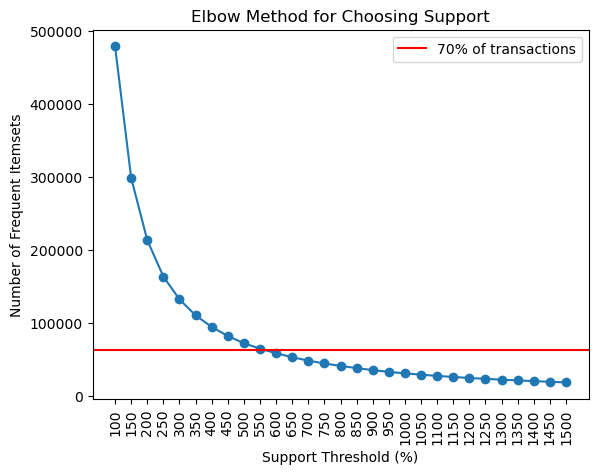

In [26]:
supports = range(100, 1501, 50)  # Test supports from 1% to 20%
num_itemsets = []

for supp in supports:
    rules = get_fim(supp*-1, transactions)
    num_itemsets.append(len(rules))

plt.plot(supports, num_itemsets, marker='o')
plt.axhline(y = len(df_merged)*0.7, color = 'r', label = '70% of transactions')
plt.xticks([x for x in range(100, 1501, 50)], rotation=90)
plt.xlabel("Support Threshold (%)")
plt.ylabel("Number of Frequent Itemsets")
plt.title("Elbow Method for Choosing Support")
plt.legend()
plt.show()

Zoom in to the Plot

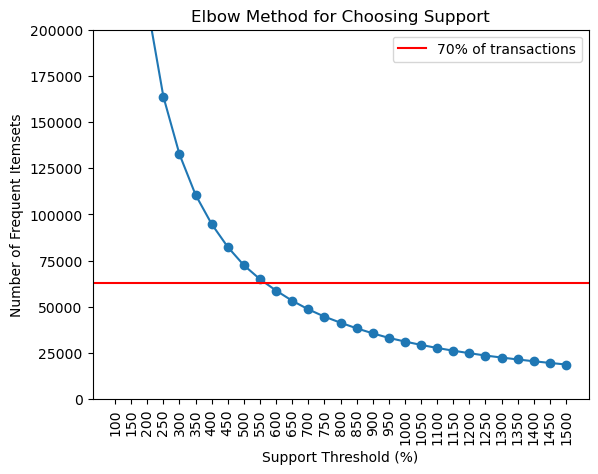

In [27]:
plt.plot(supports, num_itemsets, marker='o')
plt.axhline(y = len(df_merged)*0.7, color = 'r', label = '70% of transactions')
plt.xticks([x for x in range(100, 1501, 50)], rotation=90)
plt.xlabel("Support Threshold (%)")
plt.ylabel("Number of Frequent Itemsets")
plt.ylim([0,200_000])
plt.title("Elbow Method for Choosing Support")
plt.legend()
plt.show()

Since the "elbow" in the graph is not very observable (gradual change in slope), we chose the support value closest to 70% of the transactions (nearest point below the horizontal red line). <br/>

***Support Threshold is set to 550.***

### Frequent Itemsets

In [28]:
get_fim(-550, transactions)

,itemset,support_absolute,support_relative
0,"(duration_ms_bin_Very Low,)",89646,0.998953
2,"(speechiness_bin_Low,)",86350,0.962224
1,"(speechiness_bin_Low, duration_ms_bin_Very Low)",86262,0.961244
6,"(instrumentalness_bin_Very Low,)",69480,0.774237
3,"(instrumentalness_bin_Very Low, duration_ms_bi...",69433,0.773713
...,...,...,...
62217,"(malay, loudness_bin_High, liveness_bin_Very L...",550,0.006129
62216,"(malay, loudness_bin_High, liveness_bin_Very L...",550,0.006129
27037,"(valence_bin_High, tempo_bin_Low, popularity_b...",550,0.006129
60431,"(liveness_bin_High, danceability_bin_High, lou...",550,0.006129


### Significant Associations

In [29]:
# calculates the frequent itemset using fpgrowth algorithm
def get_sig(supp, conf, transactions):
    result = arules(transactions, supp=supp, conf=conf, report='asc')
    colnames = ['consequent', 'antecedent'] + ['support_absolute', 'support_relative', 'confidence']
    df_result = pd.DataFrame(result, columns=colnames)
    df_result = df_result.sort_values('support_absolute', ascending=False)
    return df_result

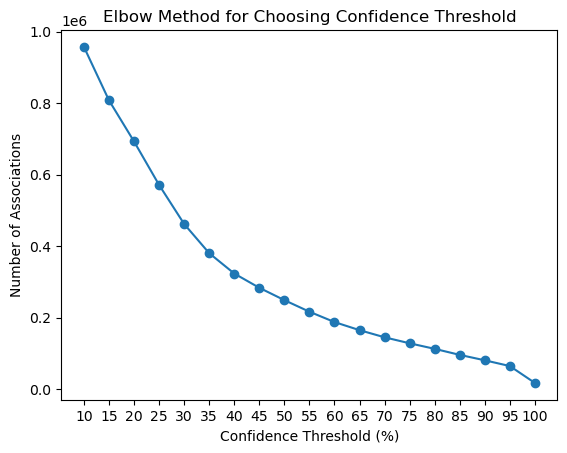

In [30]:
confidence = range(10, 101, 5)  # Test supports from 1% to 20%
freq_i_len = len(get_fim(-550, transactions))
num_itemsets = []

for conf in confidence:
    rules = get_sig(-550, conf, transactions)
    num_itemsets.append(len(rules))

plt.plot(confidence, num_itemsets, marker='o')
plt.xlabel("Confidence Threshold (%)")
plt.xticks([x for x in range(10, 101, 5)])
plt.ylabel("Number of Associations")
plt.title("Elbow Method for Choosing Confidence Threshold")
plt.show()

Since the "elbow" in the graph is not very observable (gradual change in slope) and we do not want to lose the other features, we choose low confidence threshold. <br/>

***Confidence Threshold is set to 10.***

In [31]:
rules = get_sig(-550, 10, transactions)
rules

,consequent,antecedent,support_absolute,support_relative,confidence
0,duration_ms_bin_Very Low,(),89646,0.998953,0.998953
3,speechiness_bin_Low,(),86350,0.962224,0.962224
1,duration_ms_bin_Very Low,"(speechiness_bin_Low,)",86262,0.961244,0.998981
2,speechiness_bin_Low,"(duration_ms_bin_Very Low,)",86262,0.961244,0.962252
11,instrumentalness_bin_Very Low,(),69480,0.774237,0.774237
...,...,...,...,...,...
576407,acousticness_bin_Medium,"(instrumentalness_bin_Very High, liveness_bin_...",55,0.000613,0.100000
753913,acousticness_bin_High,"(danceability_bin_Very High, valence_bin_High,...",55,0.000613,0.100000
720290,acousticness_bin_Medium,"(explicit, popularity_bin_Low, loudness_bin_Ve...",55,0.000613,0.100000
720736,explicit,"(acousticness_bin_Medium, energy_bin_High, dan...",55,0.000613,0.100000


### Interesting Associations

In [32]:
rules['interest'] = rules['confidence'] - rules['support_relative']
rules = rules.sort_values('interest', ascending=False)
rules

,consequent,antecedent,support_absolute,support_relative,confidence,interest
648127,duration_ms_bin_Very Low,"(popularity_bin_High, valence_bin_Medium, danc...",550,0.006129,1.000000,0.993871
639948,duration_ms_bin_Very Low,"(popularity_bin_High, energy_bin_High, danceab...",550,0.006129,1.000000,0.993871
920177,duration_ms_bin_Very Low,"(power-pop, popularity_bin_Low, acousticness_b...",550,0.006129,1.000000,0.993871
920182,speechiness_bin_Low,"(power-pop, popularity_bin_Low, acousticness_b...",550,0.006129,1.000000,0.993871
920178,speechiness_bin_Low,"(power-pop, popularity_bin_Low, acousticness_b...",550,0.006129,1.000000,0.993871
...,...,...,...,...,...,...
18147,popularity_bin_Medium,(),25792,0.287408,0.287408,0.000000
11959,energy_bin_Very High,(),29447,0.328137,0.328137,0.000000
5567,popularity_bin_Low,(),30030,0.334633,0.334633,0.000000
2495,danceability_bin_Medium,(),32426,0.361333,0.361333,0.000000


In [33]:
interest_threshold = 0.5
rules_filtered = rules[rules['interest'] > interest_threshold]
rules_filtered

,consequent,antecedent,support_absolute,support_relative,confidence,interest
648127,duration_ms_bin_Very Low,"(popularity_bin_High, valence_bin_Medium, danc...",550,0.006129,1.000000,0.993871
639948,duration_ms_bin_Very Low,"(popularity_bin_High, energy_bin_High, danceab...",550,0.006129,1.000000,0.993871
920177,duration_ms_bin_Very Low,"(power-pop, popularity_bin_Low, acousticness_b...",550,0.006129,1.000000,0.993871
920182,speechiness_bin_Low,"(power-pop, popularity_bin_Low, acousticness_b...",550,0.006129,1.000000,0.993871
920178,speechiness_bin_Low,"(power-pop, popularity_bin_Low, acousticness_b...",550,0.006129,1.000000,0.993871
...,...,...,...,...,...,...
99049,acousticness_bin_Low,"(valence_bin_Medium, popularity_bin_Medium, lo...",603,0.006719,0.506723,0.500003
99042,acousticness_bin_Low,"(valence_bin_Medium, popularity_bin_Medium, lo...",603,0.006719,0.506723,0.500003
686017,danceability_bin_High,"(explicit, energy_bin_High, loudness_bin_Very ...",603,0.006719,0.506723,0.500003
131590,tempo_bin_Medium,"(acousticness_bin_High, valence_bin_Low, popul...",708,0.007889,0.507891,0.500002


# Insights

In [34]:
# focus on popularity
rules_filtered = rules_filtered[rules_filtered["consequent"].astype(str).str.contains("popularity", na=False)]
rules_filtered.sort_values('confidence', ascending=False)

,consequent,antecedent,support_absolute,support_relative,confidence,interest
869483,popularity_bin_Very Low,"(iranian,)",983,0.010954,0.994939,0.983985
869409,popularity_bin_Very Low,"(iranian, duration_ms_bin_Very Low)",972,0.010831,0.994882,0.984051
869414,popularity_bin_Very Low,"(iranian, speechiness_bin_Low)",952,0.010608,0.994775,0.984167
869412,popularity_bin_Very Low,"(iranian, speechiness_bin_Low, duration_ms_bin...",942,0.010497,0.994720,0.984223
929393,popularity_bin_Medium,"(sertanejo, instrumentalness_bin_Very Low, dur...",870,0.009695,0.994286,0.984591
...,...,...,...,...,...,...
506664,popularity_bin_Low,"(valence_bin_Very High, energy_bin_High, dance...",304,0.003388,0.504146,0.500758
950760,popularity_bin_Low,"(groove, instrumentalness_bin_Very Low, speech...",311,0.003466,0.504052,0.500586
950759,popularity_bin_Low,"(groove, instrumentalness_bin_Very Low, speech...",311,0.003466,0.504052,0.500586
444016,popularity_bin_Low,"(danceability_bin_Low, energy_bin_Very High, l...",282,0.003142,0.503571,0.500429


In [35]:
genre_list = list(df['track_genre'].unique())
populars = {}
for each in ["Very Low", "Low", "Medium", "High", "Very High"]:
    genres = []
    max_len = 0
    for each_rules in rules_filtered[rules_filtered['consequent'].str.contains(each)].iloc:
        if each_rules['antecedent'][0] not in genres and each_rules['antecedent'][0] in genre_list and len(each_rules['antecedent']) > max_len:
            genres.append(each_rules['antecedent'][0])
            max_len = len(each_rules['antecedent'])
            if each not in populars.keys():
                populars[each] = [each_rules['antecedent']]
            else:
                populars[each].append(each_rules['antecedent'])

In [36]:
# statements
for each in populars:
    for each_antecedent in populars[each]:
        print(f"{each_antecedent}⇒{each} popularity")

('iranian', 'liveness_bin_Very Low', 'speechiness_bin_Low', 'duration_ms_bin_Very Low')⇒Very Low popularity
('romance', 'acousticness_bin_High', 'loudness_bin_High', 'instrumentalness_bin_Very Low', 'duration_ms_bin_Very Low')⇒Very Low popularity
('grindcore', 'energy_bin_Very High', 'tempo_bin_Medium', 'acousticness_bin_Low', 'speechiness_bin_Low', 'duration_ms_bin_Very Low')⇒Very Low popularity
('chicago-house', 'loudness_bin_High', 'tempo_bin_Medium', 'acousticness_bin_Low', 'liveness_bin_Very Low', 'speechiness_bin_Low', 'duration_ms_bin_Very Low')⇒Very Low popularity
('iranian', 'liveness_bin_Very Low', 'speechiness_bin_Low', 'duration_ms_bin_Very Low')⇒Low popularity
('romance', 'acousticness_bin_High', 'loudness_bin_High', 'instrumentalness_bin_Very Low', 'duration_ms_bin_Very Low')⇒Low popularity
('grindcore', 'energy_bin_Very High', 'tempo_bin_Medium', 'acousticness_bin_Low', 'speechiness_bin_Low', 'duration_ms_bin_Very Low')⇒Low popularity
('chicago-house', 'loudness_bin_High

## Writeup/Analysis

Recommendations
  - Based on the given association rules, the popularity of a song is influenced by features like genre, loudness, energy, acousticness, speechiness, liveness, instrumentalness, tempo, and duration.
  - If you are producing music and aiming for high popularity, it is best to focus on genres like K-pop or Pop. These genres are associated with features that contribute to increased popularity, including low acousticness, very low instrumentalness, and low speechiness. Additionally, keeping the duration very short can further enhance a song’s appeal. By incorporating these elements into your music production, you can increase the likelihood of reaching a wider audience and achieving greater success.
  - For less popular genres such as Iranian, Romance, Grindcore, and Chicago-House, increasing loudness while slightly reducing the duration may help align them with the characteristics of more popular songs. Additionally, adjusting acousticness and instrumentalness towards lower values could enhance their appeal. Since high-energy tracks, like those in the Party and Sertanejo genres, tend to engage listeners more effectively, boosting energy levels might contribute to greater popularity.

Lessons Learned
  - A lot of preprocessing may be needed depending on the original set of data to transform it into a form that can be used for association rule learning.
  - The context in which association rule learning is used is very important. Unlike the groceries dataset wherein the goal was more clearly defined, the spotify dataset, having a lot of features, was more open ended. It might not have been needed to include everything in the association rule learning section as it would depend on the goal of the analysis. Using only the relevant features to the research goal may also improve the effectiveness of association rule learning.
  - Correlation does not imply causality. Just like in the spotify dataset, it doesn't mean that very high instrumentalness and medium tempo in a song causes very low popularity. Extra analysis on the results may be done to extract useful insights

## References

- Teves, J. (n.d.) Association Rule Learning [Source code]. https://colab.research.google.com/github/Cyntwikip/Data-Mining/blob/main/association_rule_learning/association_rule_learning_homework.ipynb
- Maharshi Pandya. (2022). Spotify Tracks Dataset [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/4372070